In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import sys
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary


def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X
    
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
                 lr=0.1, num_classes=10):
        super(DenseNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                              growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(
                    num_channels))
        self.net.add_module('last', nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)

# 1. Why do we use average pooling rather than max-pooling in the transition layer?

In DenseNet architectures, transition layers are used to reduce the spatial dimensions (width and height) of feature maps while also reducing the number of feature maps (channels) before passing them to the next dense block. The choice between average pooling and max-pooling in transition layers depends on the design goals and the desired properties of the network. In DenseNet, average pooling is often preferred over max-pooling for several reasons:

1. **Feature Retention**: Average pooling computes the average value of the elements in a pooling region. This retains more information about the features compared to max-pooling, which only selects the maximum value. In DenseNet, where information from all previous layers is concatenated together, average pooling helps in maintaining a more comprehensive representation of the features.

2. **Smoothing Effect**: Average pooling has a smoothing effect on the output feature maps. This can help in reducing the risk of overfitting by preventing the network from becoming too sensitive to specific details in the data.

3. **Stability**: Average pooling is less sensitive to outliers compared to max-pooling. This can make the network more robust to noise or variations in the input data.

4. **Translation Invariance**: Average pooling provides a certain degree of translation invariance by taking into account the overall distribution of values in the pooling region. This can be beneficial in scenarios where small translations of the input should not significantly affect the output.

5. **Information Sharing**: Average pooling promotes information sharing among neighboring pixels or units. This can help in capturing global patterns and structures present in the input data.

While average pooling is preferred in transition layers, max-pooling can still have its own advantages in certain contexts. For example, in architectures like convolutional neural networks (CNNs) that prioritize capturing local features and enhancing feature maps, max-pooling can be effective. However, in DenseNet's context, where the emphasis is on maintaining rich information flow and reducing the risk of information loss, average pooling aligns better with the architecture's principles.

Ultimately, the choice between average pooling and max-pooling depends on the specific goals of the network, the characteristics of the data, and the overall design philosophy.

# 2. One of the advantages mentioned in the DenseNet paper is that its model parameters are smaller than those of ResNet. Why is this the case?

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

data = d2l.FashionMNIST(batch_size=32, resize=(224, 224))
arch18 = [(2,[(64,3,1)]*2,None),(2,[(128,3,1)]*2,128),(2,[(256,3,1)]*2,256),(2,[(512,3,1)]*2,512)]
resnet18 = d2l.ResNet(arch=arch18, lr=0.01)
resnet18.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
print(count_parameters(resnet18))
summary(resnet18, (1, 224, 224))

11523338
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Residual-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,928
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          

In [12]:
model = DenseNet(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
print(count_parameters(model))
summary(model, (1, 224, 224))

758226
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]          18,464
       BatchNorm2d-8           [-1, 96, 56, 56]             192
              ReLU-9           [-1, 96, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          27,680
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13           [-1, 32, 56, 56]          36,896
      BatchNorm2d-14          [-

The reason why DenseNet has smaller model parameters than ResNet is because DenseNet uses **dense connections** between layers, which means that each layer receives the feature maps of all preceding layers as input and passes its own feature maps to all subsequent layers. This way, the number of channels (filters) in each layer can be reduced, since the layer can reuse the features from previous layers. ResNet, on the other hand, uses **residual connections**, which means that each layer only receives the output of the previous layer and adds it to its own output. This requires more channels in each layer to learn new features, since the layer cannot access the features from earlier layers. According to the DenseNet paper¹, a 121-layer DenseNet has 7.98 million parameters, while a 152-layer ResNet has 60.19 million parameters. This is a significant difference in model size and complexity.

- (1) [1608.06993] Densely Connected Convolutional Networks - arXiv.org. https://arxiv.org/abs/1608.06993.
- (2) DenseNet Explained | Papers With Code. https://paperswithcode.com/method/densenet.
- (3) CVPR2017最佳论文DenseNet（一）原理分析 - 知乎 - 知乎专栏. https://zhuanlan.zhihu.com/p/93825208.
- (4) Densely Connected Convolutional Networks - arXiv.org. https://arxiv.org/pdf/1608.06993.pdf.
- (5) [1512.03385] Deep Residual Learning for Image Recognition - arXiv.org. https://arxiv.org/abs/1512.03385.
- (6) ResNet Explained | Papers With Code. https://paperswithcode.com/method/resnet.
- (7) arXiv:2110.00476v1 [cs.CV] 1 Oct 2021. https://arxiv.org/pdf/2110.00476.pdf.
- (8) undefined. https://doi.org/10.48550/arXiv.1608.06993.
- (9) undefined. https://doi.org/10.48550/arXiv.1512.03385.

# 3. One problem for which DenseNet has been criticized is its high memory consumption.

## 3.1 Is this really the case? Try to change the input shape to $224\times 224$ to compare the actual GPU memory consumption empirically.

In [ ]:
data = d2l.FashionMNIST(batch_size=32, resize=(28, 28))
model = DenseNet(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
memory_stats = torch.cuda.memory_stats(device=device)
# Print peak memory usage and other memory statistics
print("Peak memory usage:", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("Current memory usage:", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

In [ ]:
data = d2l.FashionMNIST(batch_size=32, resize=(224, 224))
model = DenseNet(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
memory_stats = torch.cuda.memory_stats(device=device)
# Print peak memory usage and other memory statistics
print("Peak memory usage:", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("Current memory usage:", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

## 3.2 Can you think of an alternative means of reducing the memory consumption? How would you need to change the framework?

Reducing memory consumption in a DenseNet architecture can be achieved through various strategies. One approach is to introduce sparsity into the model, which reduces the number of active connections and parameters. Here's how you might change the framework to achieve this:

**1. Sparse Connectivity in Dense Blocks:**
Instead of having fully connected dense blocks, you can introduce sparse connectivity patterns. This means that not every layer connects to every other layer in the dense block. You can achieve this by randomly selecting a subset of previous layers' feature maps to concatenate with the current layer. This reduces the number of connections and memory consumption.

**2. Channel Pruning:**
Apply channel pruning techniques to the dense blocks. You can identify less important channels and remove them from the concatenation operation. This effectively reduces the number of active channels and saves memory.

**3. Regularization and Compression:**
Introduce regularization techniques like L1 regularization during training to encourage certain weights to become exactly zero. Additionally, you can explore model compression methods like knowledge distillation or quantization to reduce the memory footprint of the model.

**4. Low-Rank Approximations:**
Perform low-rank matrix factorization on the weight matrices in the dense blocks. This technique approximates the weight matrices with lower-dimensional factors, leading to reduced memory usage.

**5. Dynamic Allocation:**
Allocate memory dynamically during inference to only store the necessary feature maps. This technique avoids allocating memory for feature maps that are no longer needed.

**6. Sparsity-Inducing Activation Functions:**
Use activation functions that naturally induce sparsity, such as the ReLU6 function, which caps activations at a maximum value and can lead to some neurons becoming inactive.

**7. Adaptive Dense Blocks:**
Design adaptive dense blocks that dynamically adjust their connectivity patterns based on the data distribution. For example, you can use attention mechanisms to determine which previous feature maps to concatenate based on their importance.

Implementing these changes would require modifications to the architecture, training procedure, and potentially custom layers or modifications to existing layers. It's important to note that these techniques might involve a trade-off between memory reduction and model performance. It's recommended to experiment and fine-tune these strategies on your specific problem domain to find the right balance.

# 4. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper (Huang et al., 2017).

In [114]:
def conv_block(num_channels, kernel_size, padding):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=kernel_size, padding=padding))

def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

class DenseBlock(nn.Module):
    def __init__(self, convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for kernel_size, padding in convs:
            layer.append(conv_block(num_channels, kernel_size, padding))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def __init__(self, num_channels=64, growth_rate=32, arch=[[[3,1],[3,1]],[[3,1],[3,1]]],lr=0.1, num_classes=10):
        super(DenseNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(convs, growth_rate))
            # The number of output channels in the previous dense block
            num_channels += len(convs) * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(
                    num_channels))
        self.net.add_module('last', nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)

In [118]:
data = d2l.FashionMNIST(batch_size=32, resize=(224, 224))
arch121 = ([[[1,0],[3,1]]*6,[[1,0],[3,1]]*12,[[1,0],[3,1]]*24,[[1,0],[3,1]]*16])
densenet121 = DenseNet(lr=0.01, arch=arch121)
densenet121.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# print(count_parameters(model))
summary(densenet121, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           2,080
       BatchNorm2d-8           [-1, 96, 56, 56]             192
              ReLU-9           [-1, 96, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          27,680
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13           [-1, 32, 56, 56]           4,128
      BatchNorm2d-14          [-1, 160,

In [ ]:
arch169 = ([[[1,0],[3,1]]*6,[[1,0],[3,1]]*12,[[1,0],[3,1]]*32,[[1,0],[3,1]]*32])
densenet169 = DenseNet(lr=0.01, arch=arch169)

In [ ]:
arch201 = ([[[1,0],[3,1]]*6,[[1,0],[3,1]]*12,[[1,0],[3,1]]*48,[[1,0],[3,1]]*32])
densenet201 = DenseNet(lr=0.01, arch=arch201)

In [ ]:
arch264 = ([[[1,0],[3,1]]*6,[[1,0],[3,1]]*12,[[1,0],[3,1]]*64,[[1,0],[3,1]]*48])
densenet264 = DenseNet(lr=0.01, arch=arch264)

# 5. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price prediction task in Section 5.7.

In [1]:
import pandas as pd
import time
from tqdm import tqdm
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import cProfile
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings("ignore")

class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(d2l.DATA_URL+ 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
            
    def preprocess(self, std_flag=True):
        label = 'SalePrice'
        features = pd.concat((self.raw_train.drop(columns=['Id',label]),
                              self.raw_val.drop(columns=['Id'])))
        numeric_features = features.dtypes[features.dtypes!='object'].index
        if std_flag:
            features[numeric_features] = features[numeric_features].apply(lambda x: (x-x.mean())/x.std())
        features[numeric_features] = features[numeric_features].fillna(0)
        features = pd.get_dummies(features, dummy_na=True)
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train[label] = self.raw_train[label]
        self.val = features[self.raw_train.shape[0]:].copy()
        
    def get_dataloader(self, train):
        label = 'SalePrice'
        data = self.train if train else self.val
        if label not in data:
            return
        get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)
        # tensors = (get_tensor(data.drop(columns=[label])),
        #            torch.log(get_tensor(data[label])).reshape(-1,1))
        tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
        return self.get_tensorloader(tensors, train)
    
def k_fold_data(data,k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j*fold_size,(j+1)*fold_size)
        rets.append(KaggleHouse(data.batch_size,data.train.drop(index=idx),data.train.iloc[idx]))
    return rets

def k_fold(trainer, data, k, ModelClass,hparams,plot_flag=True):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data,k)):
        model = ModelClass(**hparams)
        model.board.yscale='log'
        if not plot_flag or i != 0:
            model.board.display=False
        trainer.fit(model,data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    avg_val_loss = sum(val_loss)/len(val_loss)
    print(f'average validation log mse = {avg_val_loss}, params:{hparams}')
    return models, avg_val_loss



class HouseResMLP(d2l.LinearRegression):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts, weight_decay):
        super().__init__(lr)
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for i in range(len(num_hiddens)):
            layers.append(nn.Sequential(nn.LazyLinear(num_hiddens[i]),
                                        nn.ReLU(),
                                        nn.Dropout(dropouts[i]),
                                        nn.LazyBatchNorm1d(),
                                        ))
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)
                          
    def forward(self, X):
        X = self.net[0](X)
        for blk in self.net[1:-1]:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return self.net[-1](X)
    
# class HouseDenseBlock(nn.Module):
#     def __init__(self, num_hiddens):
#         super().__init__()
#         layer = []
#         for i in range(len(num_hiddens)):
#             layer.append(nn.Sequential(nn.LazyLinear(num_hiddens[i]),
#                                         nn.LazyBatchNorm1d(), nn.ReLU(),
#                                         ))
#         self.net = nn.Sequential(*layer)

#     def forward(self, X):
#         for blk in self.net:
#             Y = blk(X)
#             # Concatenate input and output of each block along the channels
#             X = torch.cat((X, Y), dim=1)
#         return X
    
# def transition_block():
#     return nn.Sequential(
#         nn.LazyBatchNorm1d(), nn.ReLU(),
#         nn.AvgPool1d(kernel_size=2, stride=2))

# class HouseResMLP(d2l.LinearRegression):
#     def __init__(self, num_outputs, arch, lr, dropouts, weight_decay):
#         super().__init__(lr)
#         self.save_hyperparameters()
#         layers = [nn.Flatten()]
#         for num_hiddens in arch:
#             layers.append(HouseDenseBlock(num_hiddens))
#             # layers.append(nn.LazyLinear(sum(num_hiddens)//4))
#         layers.append(nn.LazyLinear(num_outputs))
#         self.net = nn.Sequential(*layers)
                          
#     def forward(self, X):
#         return self.net(X)
        
#     def configure_optimizers(self):
#         return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [94]:
hparams = {'dropouts': [0]*5,
 'lr': 0.01,
 'num_hiddens': [64,32,16,8],
 'num_outputs': 1,
 'weight_decay': 0}
model = HouseResMLP(**hparams)
summary(model,(1,80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 80]               0
            Linear-2                   [-1, 64]           5,184
              ReLU-3                   [-1, 64]               0
           Dropout-4                   [-1, 64]               0
       BatchNorm1d-5                   [-1, 64]             128
            Linear-6                   [-1, 32]           4,640
              ReLU-7                   [-1, 32]               0
           Dropout-8                   [-1, 32]               0
       BatchNorm1d-9                   [-1, 32]              64
           Linear-10                   [-1, 16]           2,832
             ReLU-11                   [-1, 16]               0
          Dropout-12                   [-1, 16]               0
      BatchNorm1d-13                   [-1, 16]              32
           Linear-14                   

In [2]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape, data.raw_val.shape)
data.preprocess()

(1460, 81) (1459, 80)


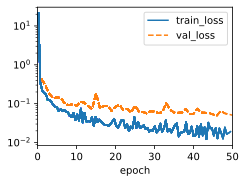

In [ ]:
hparams = {'dropouts': [0]*5,
 'lr': 0.01,
 'num_hiddens': [64,32,16],
 'num_outputs': 1,
 'weight_decay': 0}
trainer = d2l.Trainer(max_epochs=50)
models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseResMLP,hparams=hparams,plot_flag=True)

In [4]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32)) for model in models]
ensemble_preds = torch.exp(torch.cat(preds,1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)